In [ ]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from keras.datasets import cifar100
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
num_classes = 100
nb_epochs = 10

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
datagen.fit(x_train)

169009152/169001437 [==============================] - 6s 0us/step


In [ ]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 14.5MB/s 


In [ ]:
import tensorflow_addons as tfa

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=tfa.optimizers.AdamW(weight_decay=5e-5
                                                                             ),metrics=['accuracy'])

t=time.time()
historytemp = model.fit(datagen.flow(x_train, y_train,
                                  batch_size=64),
                                  steps_per_epoch=x_train.shape[0] // 64,
                                  epochs=15,
                                  validation_data=datagen.flow(x_test, y_test))
print('Training time: %s' % (t - time.time()))

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/resnet_tr_learning/model_15_epochs.h5')
model.save_weights('/content/drive/MyDrive/resnet_tr_learning/weights_15_epochs.h5')

In [ ]:
import pandas as pd
df = pd.DataFrame({'train_loss': historytemp.history['loss'], 'val_loss': historytemp.history['val_loss'], 'train_acc': historytemp.history['accuracy'], 'val_acc': historytemp.history['val_accuracy']})

In [ ]:
df.to_csv('/content/drive/MyDrive/resnet_tr_learning/results_15_epochs.csv', index=False)

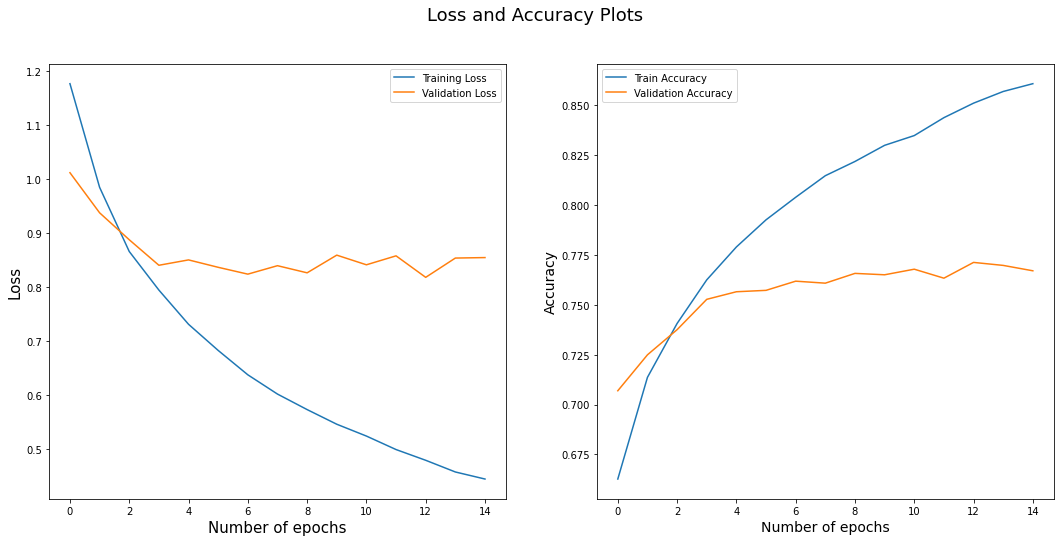

In [ ]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(historytemp.history['loss'], label='Training Loss')
plt.plot(historytemp.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(historytemp.history['accuracy'], label='Train Accuracy')
plt.plot(historytemp.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) multiple                  0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 multiple                  0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  524544    
_________________________________________________________________
dropout (Dropout)            multiple                  0